In [1]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import pandas as pd

from pathlib import Path

In [2]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected.csv")
X_test = pd.read_csv(path / "X_test_selected.csv")
y_train = pd.read_csv(path / "y_train.csv")
y_test = pd.read_csv(path / "y_test.csv")

print(X_train.shape, X_test.shape)

(1934, 11) (215, 11)


In [3]:
RANDOM_STATE = 42
CV_SPLITS = 5
SEARCH_ITER = 20
SCORING = "roc_auc_ovr"  # chosen because we will tune treshold later; could be recall_macro or f1_macro

# The pipeline
pipe = Pipeline(
    steps=[
        (
            "svm",
            SVC(probability=True),
        ),
    ]
)

# Define the hyperparameter search space
search_space = {
    "svm__C": Real(1e-3, 1e3, prior="log-uniform"),
    "svm__gamma": Real(1e-4, 1e1, prior="log-uniform"),
    "svm__kernel": Categorical(["rbf", "linear"]),
}

# Stratified CV
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Bayesian search wrapper
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_space,
    n_iter=SEARCH_ITER,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE,
    verbose=0,
)

In [4]:
import warnings

warnings.filterwarnings("ignore")
bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_

In [5]:
print("Best score:", bayes_search.best_score_)
print("Best params:", bayes_search.best_params_)

Best score: 0.9306555603263202
Best params: OrderedDict([('svm__C', 1000.0), ('svm__gamma', 0.005115502816901849), ('svm__kernel', 'rbf')])


AUC: 0.9395115486558122


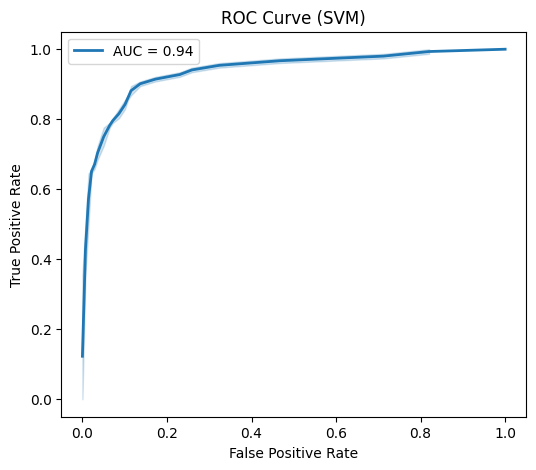

In [6]:
import sys

sys.path.append(".")
sys.path.append("..")

from helpers.roc_utils import plot_roc

auc = plot_roc(best_model, X_test, y_test, title="ROC Curve (SVM)")
print("AUC:", auc)

In [7]:
import pickle

model_path = Path("../data/models")
model_path.mkdir(parents=True, exist_ok=True)

with open(model_path / "SVM_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)